In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from src.HyperHeuristic import HyperHeuristic
# from src.stop.NoImprovement import NoImprovement
# from src.stop.MaxRuntime import MaxRuntime
from src.stop.MaxRuntimeOrNoImprovement import MaxRuntimeOrNoImprovement
from src.weights.SegmentedWeights import SegmentedWeights
from src.accept.SimulatedAnnealing import SimulatedAnnealing
from src.accept.RandomWalk import RandomWalk
from src.accept.RecordToRecordTravel import RecordToRecordTravel
from src.accept.HillClimbing import HillClimbing
from src.initial_solution.ConstructiveHeuristic import RandomConstructive, GreedyRandomizedConstructive, GreedyConstructive
from src.operators.DestroyOperators import RandomRemove, WorstRemove, ShawRemove 
from src.operators.RepairOperators import RandomRepair, GreedyRepair, RegretInsertion
from src.local_search.LocalSearch import FirstImprovement, BestImprovement
from src.KnapsackInstance import KnapsackInstance
from utils.benchmark import BinaryKnapsackBenchmark
from utils.knapsackSortFunctions import sortIndexesByProfitWeightDensity

In [3]:
benchmarkPath = "./backup/data/benchmark/binaryKnapsack"
benchmark = BinaryKnapsackBenchmark("binary", benchmarkPath)
instancesList = benchmark.getInstancesList()
np.random.shuffle(instancesList)

In [58]:
instances = [
    "n_800_c_100000000_g_6_f_0.1_eps_0.1_s_300/test.in",
    "n_1200_c_10000000000_g_6_f_0.2_eps_0.1_s_200/test.in",
    "n_600_c_100000000_g_14_f_0.3_eps_0.001_s_300/test.in",
    "n_400_c_10000000000_g_14_f_0.3_eps_0.01_s_200/test.in",
    "n_600_c_100000000_g_2_f_0.1_eps_0.01_s_100/test.in",
    "n_600_c_10000000000_g_2_f_0.2_eps_0_s_200/test.in",
    "n_600_c_10000000000_g_6_f_0.3_eps_0.01_s_300/test.in",
    "n_800_c_1000000_g_14_f_0.1_eps_0.1_s_100/test.in",
    "n_600_c_100000000_g_2_f_0.1_eps_0.1_s_300/test.in",
    "n_1200_c_100000000_g_6_f_0.3_eps_0.1_s_200/test.in",
    "n_800_c_10000000000_g_14_f_0.2_eps_0.1_s_300/test.in",
    "n_600_c_100000000_g_6_f_0.2_eps_1e-05_s_100/test.in",
    "n_1200_c_100000000_g_14_f_0.2_eps_0_s_100/test.in",
    "n_400_c_1000000_g_2_f_0.2_eps_0_s_200/test.in",
    "n_1000_c_1000000_g_14_f_0.2_eps_0.1_s_100/test.in",
    "n_1000_c_100000000_g_2_f_0.2_eps_0.01_s_300/test.in",
    "n_1000_c_100000000_g_6_f_0.3_eps_0_s_200/test.in",
    "n_1200_c_1000000_g_10_f_0.2_eps_0.001_s_100/test.in",
    "n_400_c_10000000000_g_6_f_0.1_eps_0_s_200/test.in",
    "n_400_c_100000000_g_2_f_0.3_eps_0.0001_s_100/test.in"
]

In [59]:
columns = ['instanceName', 'optimumFO', 'FO', 'relativeError', 'runtime', 'foEvolution', 'weightEvolution']
values = []

for instanceName in instances:
# for instanceName in pd.read_csv('summary.csv').instanceName.apply(lambda x: x + "/test.in").values:
    # Create Hyper-Heuristic
    hyperHeuristic = HyperHeuristic()

    randomRemove1 = RandomRemove(0.2)
    randomRemove2 = RandomRemove(0.4)
    worstRemove1 = WorstRemove(0.2)
    worstRemove2 = WorstRemove(0.4)
    randomRepair = RandomRepair()
    greedyRepair = GreedyRepair()

    hyperHeuristic.add_refinement(randomRemove1, 'randomRemove0.2')
    hyperHeuristic.add_refinement(randomRemove2, 'randomRemove0.4')
    hyperHeuristic.add_refinement(worstRemove1, 'worstRemove0.2')
    hyperHeuristic.add_refinement(worstRemove2, 'worstRemove0.4')
    hyperHeuristic.add_refinement(randomRepair, 'randomRepair')
    hyperHeuristic.add_refinement(greedyRepair, 'greedyRepair')

    firstImprovement = FirstImprovement()
    hyperHeuristic.add_refinement(firstImprovement, 'firstImprovement')

    randomConstruct = RandomConstructive()
    greedyConstruct = GreedyConstructive(sortIndexesByProfitWeightDensity)
    greedyRandomizedConstruct = GreedyRandomizedConstructive(0.3)
    hyperHeuristic.add_refinement(randomConstruct, 'randomConstruct')
    hyperHeuristic.add_refinement(greedyConstruct, 'greedyConstruct')
    hyperHeuristic.add_refinement(greedyRandomizedConstruct, 'greedyRandomizedConstruct')

    simulatedAnnealingCriteria = SimulatedAnnealing(
        start_temperature = 100,
        end_temperature = 0.001,
        step = 0.99,
        method = 'exponential'
    )

    recordToRecordTravel = RecordToRecordTravel(
        start_threshold = 0.5,
        end_threshold = 0.1,
        step = 0.01,
        method = 'linear',
        cmp_best = True
    )

    # hillClimbing = HillClimbing()
    # randomWalk = RandomWalk()

    # hyperHeuristic.add_acceptance(simulatedAnnealingCriteria, 'simulatedAnnealingCriteria')
    hyperHeuristic.add_acceptance(recordToRecordTravel, 'recordToRecordTravel')
    # hyperHeuristic.add_acceptance(hillClimbing, 'hillClimbing')

    segWeights = SegmentedWeights(
        scores = [5,4,1,0.5],
        refinements = hyperHeuristic.refinement,
        acceptances = hyperHeuristic.acceptance,
        seg_decay = 0.8,
        seg_length = 100
    )

    # stop = NoImprovement(max_iterations = 10)
    # stop = MaxRuntime(45)
    stop = MaxRuntimeOrNoImprovement(max_runtime = 45, max_iterations = 200)

    # Run instance
    # instanceName = np.random.choice(instancesList)
    print(instanceName)
    instance = benchmark.parseInstance(instanceName)
    optimum = benchmark.getOptimalFO(instanceName)

    result = hyperHeuristic.iterate(instance, segWeights, stop, constructive_heuristic_name = 'randomConstruct')
    objective = result.best_state.objective(isMinimizing = False)
    runtime = result.statistics.total_runtime
    foEvolution = result.objectives
    weightEvolution = result.refinement_weights
    
    values.append([
        instanceName.replace('/test.in',''),
        optimum,
        objective, 
        (optimum - objective)/optimum,
        runtime,
        foEvolution, 
        weightEvolution
    ])

summary = pd.DataFrame(data = values, columns = columns)
summary.head()

n_800_c_100000000_g_6_f_0.1_eps_0.1_s_300/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_1200_c_10000000000_g_6_f_0.2_eps_0.1_s_200/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_600_c_100000000_g_14_f_0.3_eps_0.001_s_300/test.in
n_400_c_10000000000_g_14_f_0.3_eps_0.01_s_200/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_600_c_100000000_g_2_f_0.1_eps_0.01_s_100/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_600_c_10000000000_g_2_f_0.2_eps_0_s_200/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_600_c_10000000000_g_6_f_0.3_eps_0.01_s_300/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_800_c_1000000_g_14_f_0.1_eps_0.1_s_100/test.in
n_600_c_100000000_g_2_f_0.1_eps_0.1_s_300/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_1200_c_100000000_g_6_f_0.3_eps_0.1_s_200/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_800_c_10000000000_g_14_f_0.2_eps_0.1_s_300/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_600_c_100000000_g_6_f_0.2_eps_1e-05_s_100/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_1200_c_100000000_g_14_f_0.2_eps_0_s_100/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_400_c_1000000_g_2_f_0.2_eps_0_s_200/test.in
n_1000_c_1000000_g_14_f_0.2_eps_0.1_s_100/test.in
n_1000_c_100000000_g_2_f_0.2_eps_0.01_s_300/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_1000_c_100000000_g_6_f_0.3_eps_0_s_200/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_1200_c_1000000_g_10_f_0.2_eps_0.001_s_100/test.in
n_400_c_10000000000_g_6_f_0.1_eps_0_s_200/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


n_400_c_100000000_g_2_f_0.3_eps_0.0001_s_100/test.in


/mnt/c/Users/caina/OneDrive/Área de Trabalho/UFRJ/Mestrado/OTIMIA/hyper-heuristics/utils/instancesRepresentation.py:76: RuntimeWarning: overflow encountered in long_scalars
  foValue -= noFeasiblePenalty * (totalKnapsacksWeights[knapsack] - knapsacksCapacities[knapsack])


,instanceName,optimumFO,FO,relativeError,runtime,foEvolution,weightEvolution
0,n_800_c_100000000_g_6_f_0.1_eps_0.1_s_300,99388338,98139069,1.256957e-02,3.303255,"[-inf, -inf, -inf, 95012729, -inf, -inf, -inf,...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."
1,n_1200_c_10000000000_g_6_f_0.2_eps_0.1_s_200,9937526288,9812526761,1.257854e-02,11.615742,"[-1885927895751336807, -1885927895751336807, -...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."
2,n_600_c_100000000_g_14_f_0.3_eps_0.001_s_300,100024526,100018753,5.771584e-05,2.782607,"[-5243145413274593462, -5243145413274593462, -...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."
3,n_400_c_10000000000_g_14_f_0.3_eps_0.01_s_200,-1,9953138600,9.953139e+09,1.382840,"[-1653242595266387388, -1653242595266387388, -...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."
4,n_600_c_100000000_g_2_f_0.1_eps_0.01_s_100,51003102,51003102,0.000000e+00,2.469832,"[-4541009117578419707, -4541009117578419707, -...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."


In [ ]:
summary.to_csv("experimento-20-critRecordToRecord.csv", index = False)

In [28]:
# from copy import copy


# nInstance = copy(instance)
# nInstance.solution = np.array([1 for i in range(nInstance.numberOfItems)], dtype = int)
# inst = randomConstruct(nInstance, np.random.RandomState(5))
# inst.objective(isMinimizing = False)

0

<AxesSubplot:>

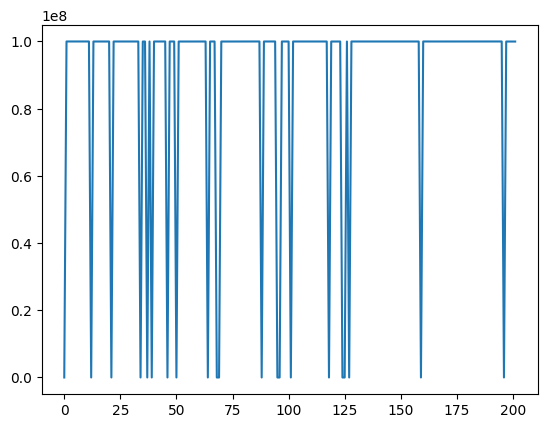

In [44]:
pd.Series(summary.iloc[-1]['foEvolution']).plot()

In [6]:
summary = pd.DataFrame(data = values, columns = columns)
summary.head()

,instanceName,optimumFO,FO,relativeError,runtime,foEvolution,weightEvolution
0,n_600_c_1000000_g_10_f_0.1_eps_0.001_s_200,1009921,1009921,0.000000e+00,1.698191,"[0, 989192, 989192, 989192, 989192, 989192, 98...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."
1,n_400_c_100000000_g_14_f_0.2_eps_0.01_s_200,100009530,99987909,2.161894e-04,4.706612,"[0, 99269949, 99269949, 99269949, 99168561, 99...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."
2,n_600_c_10000000000_g_2_f_0.1_eps_0_s_100,5000003115,5000003115,0.000000e+00,9.491099,"[0, 5000003115, 5000003115, 5000003115, 500000...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."
3,n_400_c_100000000_g_2_f_0.2_eps_1e-05_s_200,50009187,50009187,0.000000e+00,6.273390,"[0, 0, 50009121, 0, 50009034, 50009187, 500091...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."
4,n_400_c_10000000000_g_10_f_0.2_eps_0_s_300,9980505940,9980499863,6.088870e-07,11.307768,"[0, 9980486281, 9980486281, 9980486281, 998048...","[{'randomRemove0.2': 1.0, 'randomRemove0.4': 1..."


(9200000000.0, 9938000000.0)

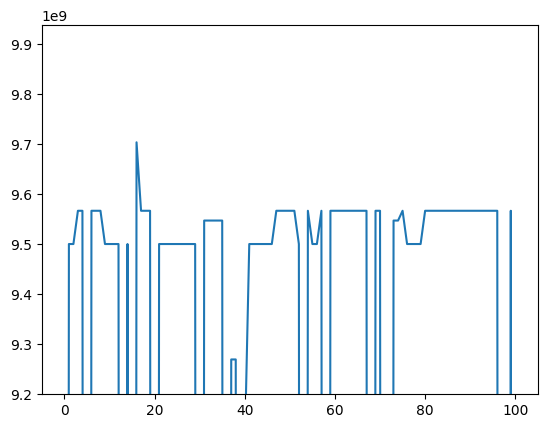

In [83]:
import numpy as np
import matplotlib.pyplot as plt
fig = pd.Series(summary['foEvolution'][1]).plot()
plt.ylim([9200000000,9938000000])

In [59]:
eval(pd.read_csv("experimento.csv")['weightEvolution'][0])[1]

{'randomRemove0.2': 1.0,
 'randomRemove0.4': 1.0,
 'worstRemove0.2': 1.0,
 'worstRemove0.4': 1.0,
 'randomRepair': 1.0,
 'greedyRepair': 1.0,
 'firstImprovement': 1.0,
 'randomConstruct': 1.0,
 'greedyConstruct': 1.0,
 'greedyRandomizedConstruct': 1.0}

In [22]:
pd.merge(summary, pd.read_csv('summary2.csv')[['instanceName', 'relativeError']], on = 'instanceName', how = 'left')

,instanceName,optimumFO,FO,relativeError_x,runtime,relativeError_y
0,n_1200_c_1000000_g_14_f_0.3_eps_0.1_s_100,1006688,968703,3.773264e-02,58.923728,3.773264e-02
1,n_400_c_10000000000_g_2_f_0.1_eps_1e-05_s_100,5000101912,5000101912,0.000000e+00,45.011591,0.000000e+00
2,n_600_c_1000000_g_14_f_0.2_eps_0.01_s_100,1005968,1004601,1.358890e-03,45.767097,1.358890e-03
3,n_800_c_10000000000_g_14_f_0.1_eps_0.01_s_200,-1,9999863063,9.999863e+09,48.016668,9.994590e+09
4,n_400_c_100000000_g_2_f_0.2_eps_0.0001_s_100,50014064,50014064,0.000000e+00,45.581524,0.000000e+00
5,n_1200_c_100000000_g_2_f_0.2_eps_0.0001_s_300,50047874,50047874,0.000000e+00,67.072951,1.998087e-08
6,n_600_c_100000000_g_10_f_0.1_eps_0_s_200,99832372,99827494,4.886191e-05,46.525372,4.886191e-05
7,n_600_c_1000000_g_10_f_0.3_eps_1e-05_s_300,1021901,1021826,7.339263e-05,45.036281,7.339263e-05
8,n_800_c_100000000_g_6_f_0.2_eps_0.001_s_200,99996356,99695333,3.010340e-03,52.357694,3.010340e-03
9,n_800_c_1000000_g_10_f_0.2_eps_0_s_100,1007744,1007533,2.093786e-04,45.722348,2.093786e-04


In [19]:
summary.to_csv('summary2.csv', index = True)